# Data Capture

In [240]:
parameter_key = [("Instantaneous computed discharge", "00060"),
                 ("Instantaneous water temperature", "00010"),
                 ("Instantaneous pH", "00400"),
                 ("Instantaneous diss. oxygen", "00300"),
                 ("Instantaneous specific conductance at 25 degrees Celsius", "00095"),
                 ("Instantaneous turbidity", "63680"),
                 ("Computed instantaneous total organic carbon", "00680"),
                 ("Computed instantaneous diss. nitrate + nitrite", "00631"),
                 ("Computed instantaneous total phosphorus", "00665")]

In [241]:
import requests
import pandas as pd
from io import StringIO
import time

def fetch_usgs_data(pcode: tuple, period: str = "2024") -> pd.DataFrame:
    """
    Fetch data from USGS NRTWQ for given site number, parameter code, period, and time step.
    
    Args:
        site_no (str): Site number, e.g. "08068500"
        pcode (str): Parameter code, e.g. "00010"
        period (str): Time period, default "2024_all"
        timestep (str): Time step, default "uv" (unit‐value)
        
    Returns:
        pd.DataFrame: Tab‐delimited DataFrame of the data
    """
    url = (
        "https://nrtwq.usgs.gov/explore/datatable?"
        f"site_no=08068500&pcode={pcode[1]}&period={period}_all&timestep=uv&format=rdb&is_verbose=y"
    )
    
    response = requests.get(url)
    response.raise_for_status()  # raises an error if the fetch failed
    # The content is text, tab‐delimited, with comment lines beginning with “#”
    # Use StringIO to put into pandas
    raw = response.text
    # print(raw)

    # Drop the comment lines (lines starting with '#')
    lines = [line for line in raw.splitlines() if not line.startswith('#')]
    stop = 0
    i = 0
    for line in lines:
        if "01/01" in line and "01:00" in line:
            stop = i
            break
        i += 1
    lines = lines[:stop+1]
    lines = [lines[0]] + lines[2:]
    cleaned = "\n".join(lines)
    # Read into DataFrame
    df = pd.read_csv(StringIO(cleaned), sep='\t', comment='#', low_memory=False)
    df['DateTime'] = pd.to_datetime(df['Date-Time'], format='%m/%d/%Y %H:%M')
    df.set_index('DateTime', inplace=True)
    df.drop(columns = ['Date-Time'], inplace=True)
    # Drop all columns other than pcode[0]
    keep_cols = [col for col in df.columns if pcode[0] == col]
    df = df[keep_cols]
    df = df[~df.index.duplicated(keep='first')]

    return df

def fetch_many_years(pcode: tuple, start_year: int, end_year: int) -> pd.DataFrame:
    """Fetch data for multiple years and concatenate into a single DataFrame."""
    dfs = []
    for year in range(start_year, end_year + 1):
        # print(f"Fetching data for year {year}...")
        df_year = fetch_usgs_data(pcode=pcode, period=str(year))
        dfs.append(df_year)
        time.sleep(1)  # Pause for 1 second between requests
    combined_df = pd.concat(dfs)
    return combined_df

def fetch_all_parameters(start_year: int, end_year: int) -> pd.DataFrame:
    """Fetch data for all parameters and concatenate into a single DataFrame."""
    dfs = []
    for pcode in parameter_key:
        print(f"Fetching data for parameter {pcode[0]}...")
        df_param = fetch_many_years(pcode=pcode, start_year=start_year, end_year=end_year)
        dfs.append(df_param)
    combined_df = pd.concat(dfs, axis=1, join='inner')
    # Sort by index
    combined_df.sort_index(inplace=True)
    return combined_df

In [242]:
df = fetch_all_parameters(start_year=2020, end_year=2024) # Has trouble loading 2018-2020, but data exists

Fetching data for parameter Instantaneous computed discharge...
Fetching data for parameter Instantaneous water temperature...
Fetching data for parameter Instantaneous pH...
Fetching data for parameter Instantaneous diss. oxygen...
Fetching data for parameter Instantaneous specific conductance at 25 degrees Celsius...
Fetching data for parameter Instantaneous turbidity...
Fetching data for parameter Computed instantaneous total organic carbon...
Fetching data for parameter Computed instantaneous diss. nitrate + nitrite...
Fetching data for parameter Computed instantaneous total phosphorus...


In [243]:
df

,Instantaneous computed discharge,Instantaneous water temperature,Instantaneous pH,Instantaneous diss. oxygen,Instantaneous specific conductance at 25 degrees Celsius,Instantaneous turbidity,Computed instantaneous total organic carbon,Computed instantaneous diss. nitrate + nitrite,Computed instantaneous total phosphorus
DateTime,,,,,,,,,
2020-01-01 01:00:00,96.0,12.2,7.3,9.8,438,39.0,11,3.03,0.911
2020-01-01 02:00:00,93.0,12.2,7.3,9.8,439,46.0,12,3.05,0.938
2020-01-01 03:00:00,93.0,12.2,7.3,9.8,440,39.0,11,3.06,0.916
2020-01-01 04:00:00,90.0,12.2,7.3,9.8,440,40.0,11,3.07,0.918
2020-01-01 05:00:00,88.0,12.2,7.3,9.7,439,41.0,12,3.07,0.920
...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,260.0,18.0,7.4,8.6,234,99.0,14,1.05,0.483
2024-12-31 20:00:00,255.0,17.6,7.4,8.6,238,95.0,14,1.08,0.490
2024-12-31 21:00:00,248.0,17.2,7.4,8.6,240,93.0,14,1.09,0.493


## Fetch Rainfall

In [246]:
# Data from TexasMesonet: https://www.texasmesonet.org/DataProducts/CustomDownloads?
import os
import pandas as pd

def load_rainfall(folder):
    combined = []
    for file in os.listdir(folder):
        df = pd.read_csv(os.path.join(folder, file))
        combined.append(df)

    df = pd.concat(combined)

    # Parse timestamps as naive 
    df['DateTime'] = pd.to_datetime(df[' Date_Time (UTC)'], utc=True)
    # Assume timzeone is correct
    # Make index timezone-naive but in Texas local time
    df.index = df['DateTime'].dt.tz_localize(None)

    df.sort_index(inplace=True)

    # Resample per hour
    return pd.DataFrame(df['Precipitation 1hr (in)'].resample('h').sum())
rain = load_rainfall("Input")

In [247]:
full_index = pd.date_range(
    start="2020-01-01 00:00:00",
    end="2024-12-31 23:00:00",
    freq="h"
)
df = df.reindex(full_index)


In [248]:
df = df.join(rain, how="left")

In [273]:
df['Precipitation 1hr (in)'] = df['Precipitation 1hr (in)'].fillna(0)

In [276]:
# df['Water Temperature (C)'].ffill().plot()

In [277]:
df.describe()

,Discharge (cfs),Water Temperature (C),pH (std units),Dissolved Oxygen (mg/L),Specific Conductance (uS/cm),Turbidity (NTU),Precipitation 1hr (in)
count,38540.000000,38540.000000,38540.000000,38540.000000,38540.000000,38540.000000,43848.000000
mean,346.353168,22.446391,7.583441,8.318612,428.975895,48.714167,0.039579
std,984.160164,6.769300,0.452200,1.809451,179.811929,50.683179,0.450727
min,6.100000,2.100000,6.200000,3.500000,33.000000,2.400000,0.000000
25%,42.000000,17.100000,7.300000,7.000000,296.000000,17.000000,0.000000
50%,76.000000,22.900000,7.500000,8.200000,427.000000,32.000000,0.000000
75%,197.000000,27.800000,7.700000,9.500000,539.000000,62.000000,0.000000
max,13300.000000,38.200000,9.900000,18.600000,1140.000000,1000.000000,23.190000


In [278]:
df.isna().sum()

Discharge (cfs)                 5308
Water Temperature (C)           5308
pH (std units)                  5308
Dissolved Oxygen (mg/L)         5308
Specific Conductance (uS/cm)    5308
Turbidity (NTU)                 5308
Total Organic Carbon (mg/L)     5308
Nitrate + Nitrite (mg/L)        5308
Total Phosphorus (mg/L)         5308
Precipitation 1hr (in)             0
dtype: int64

In [279]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43848 entries, 2020-01-01 00:00:00 to 2024-12-31 23:00:00
Freq: h
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Discharge (cfs)               38540 non-null  float64
 1   Water Temperature (C)         38540 non-null  float64
 2   pH (std units)                38540 non-null  float64
 3   Dissolved Oxygen (mg/L)       38540 non-null  float64
 4   Specific Conductance (uS/cm)  38540 non-null  float64
 5   Turbidity (NTU)               38540 non-null  float64
 6   Total Organic Carbon (mg/L)   38540 non-null  object 
 7   Nitrate + Nitrite (mg/L)      38540 non-null  object 
 8   Total Phosphorus (mg/L)       38540 non-null  object 
 9   Precipitation 1hr (in)        43848 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.7+ MB


In [280]:
column_map = {
    "Instantaneous computed discharge": "Discharge (cfs)",
    "Instantaneous water temperature": "Water Temperature (C)",
    "Instantaneous pH": "pH (std units)",
    "Instantaneous diss. oxygen": "Dissolved Oxygen (mg/L)",
    "Instantaneous specific conductance at 25 degrees Celsius": "Specific Conductance (uS/cm)",
    "Instantaneous turbidity": "Turbidity (NTU)",
    "Computed instantaneous total organic carbon": "Total Organic Carbon (mg/L)",
    "Computed instantaneous diss. nitrate + nitrite": "Nitrate + Nitrite (mg/L)",
    "Computed instantaneous total phosphorus": "Total Phosphorus (mg/L)"}
df.rename(columns=column_map, inplace=True)

In [281]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

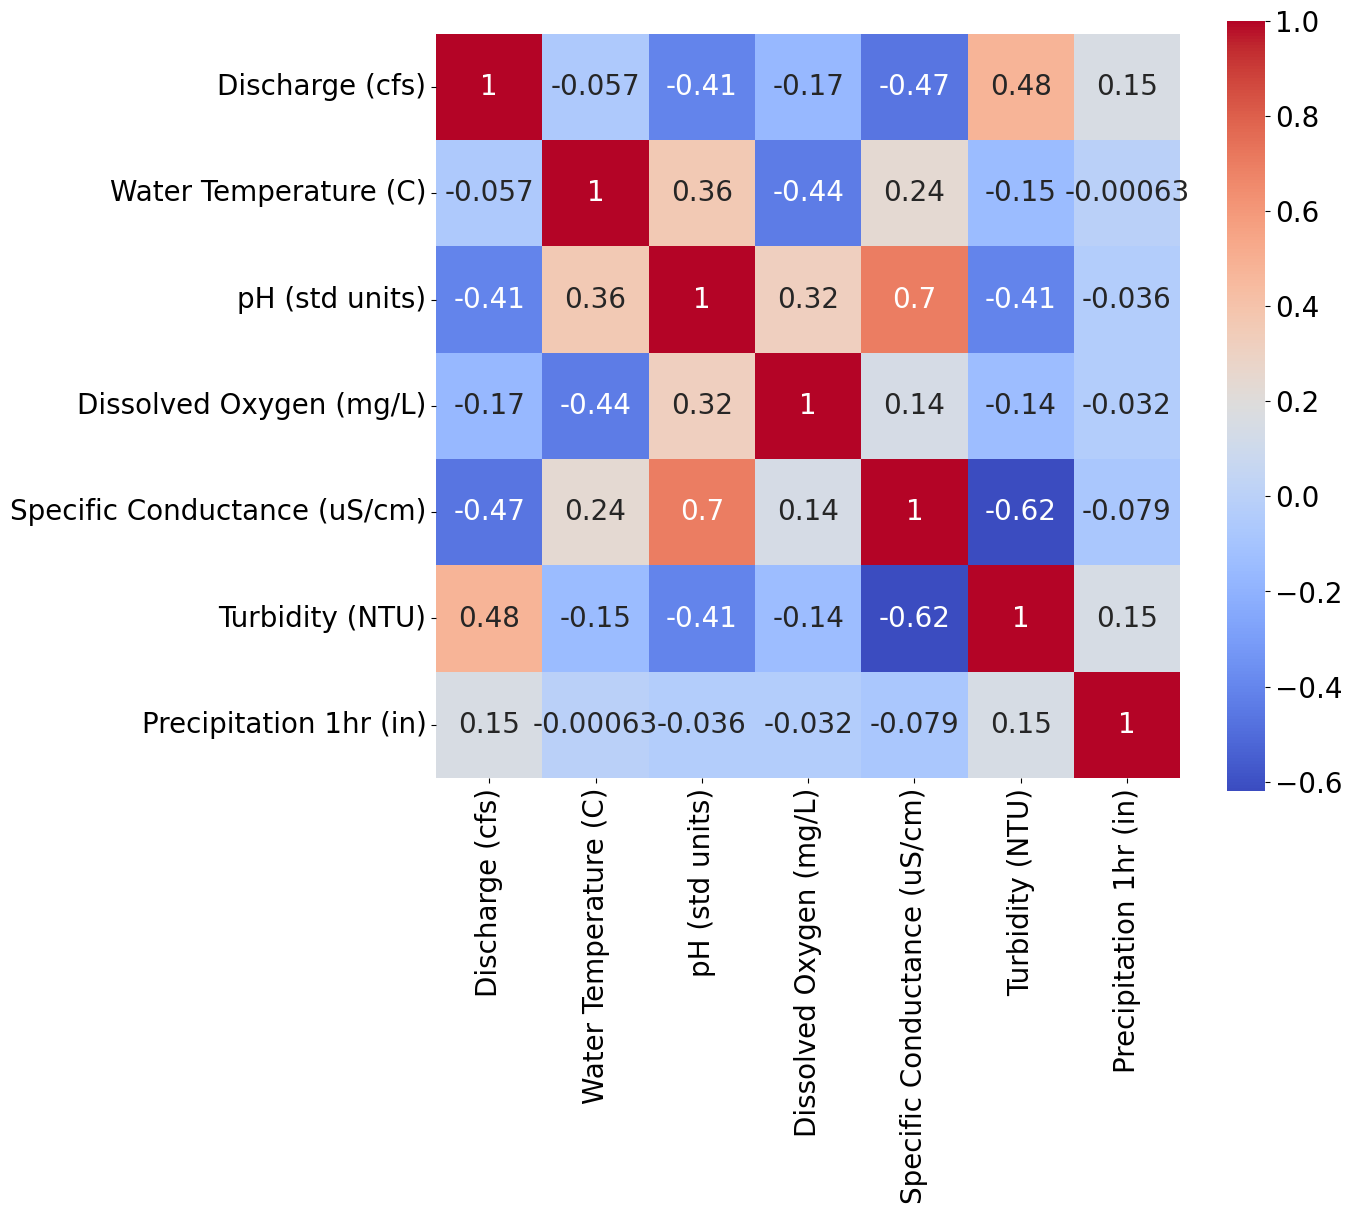

In [282]:
fig, ax = plt.subplots(figsize=(12,10))
num_cols = df.select_dtypes(include=[np.number]).columns
num_cols = num_cols[:]
#num_cols = num_cols.append(merged.columns[-1:])
corr = df[num_cols].corr(numeric_only=True)
plt.rcParams['font.size'] = 20
sns.heatmap(corr, annot=True, cmap="coolwarm",ax=ax)
ax.set_aspect(1)

In [286]:
df.index.name = "DateTime"

In [287]:
df.to_csv("swift_creek_usgs_data_2020_2024.csv")

In [288]:
df

,Discharge (cfs),Water Temperature (C),pH (std units),Dissolved Oxygen (mg/L),Specific Conductance (uS/cm),Turbidity (NTU),Total Organic Carbon (mg/L),Nitrate + Nitrite (mg/L),Total Phosphorus (mg/L),Precipitation 1hr (in)
DateTime,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2020-01-01 01:00:00,96.0,12.2,7.3,9.8,438.0,39.0,11,3.03,0.911,0.0
2020-01-01 02:00:00,93.0,12.2,7.3,9.8,439.0,46.0,12,3.05,0.938,0.0
2020-01-01 03:00:00,93.0,12.2,7.3,9.8,440.0,39.0,11,3.06,0.916,0.0
2020-01-01 04:00:00,90.0,12.2,7.3,9.8,440.0,40.0,11,3.07,0.918,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,260.0,18.0,7.4,8.6,234.0,99.0,14,1.05,0.483,0.0
2024-12-31 20:00:00,255.0,17.6,7.4,8.6,238.0,95.0,14,1.08,0.490,0.0
2024-12-31 21:00:00,248.0,17.2,7.4,8.6,240.0,93.0,14,1.09,0.493,0.0
